# Simple VAE

Author : Henri Desvallees (desvallees@ircam.fr)


In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('dark_background')
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#from torch.utils.tensorboard import SummaryWriter
#device = "cpu"
print(device)
from IPython.display import display, Audio

train = True
trainBeta = False

cpu


In [2]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.ReLU())
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        
        mu, sigma = z_params
        
        var = sigma * sigma
        log_var = torch.log(var)
        z = torch.randn_like(mu) * sigma + mu        
        kl_div = (1/2) * (mu * mu + var - log_var - 1).sum()
        
        return z, kl_div

In [4]:
class Decoder(nn.Module):
    def __init__(self, nin, n_latent = 16, n_hidden = 512, n_classes = 1,conv_channels = 1):
        super(Decoder, self).__init__()
        self.conv_channels = conv_channels
        self.Lin1 = nn.Linear(n_latent, n_hidden)
        self.Lin2 = nn.Linear(n_hidden, ((28-8)**2)*32)
        self.ConvT1 = nn.ConvTranspose2d(32, 16, 5, stride = 1)
        self.ConvT2 = nn.ConvTranspose2d(16, 1, 5, stride = 1)
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h = self.ReLU(self.Lin1(x))
        h = self.ReLU(self.Lin2(h))
        h = h.reshape(-1, 32, 28-8, 28-8)
        #h = self.ReLU(self.ConvT1(h))
        h = self.ReLU(self.ConvT1(h))
        x_hat = self.Sigmoid(self.ConvT2(h))
        return x_hat
        
        

def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1,conv_channels = 1):
    # Encoder network
    encoder = nn.Sequential(
        nn.Conv2d(1, 16, 5, stride = 1), nn.ReLU(),
        nn.Conv2d(16, 32, 5, stride = 1), nn.ReLU(),
        #nn.Conv2d(conv_channels,conv_channels,3,padding = 1), nn.ReLU(),
        nn.Flatten(),
        nn.Linear(((28-8)**2)*32, n_hidden), nn.ReLU(),
        #nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = Decoder(nin = nin,n_latent = n_latent, n_classes=n_classes,conv_channels = conv_channels)
    return encoder, decoder

# Evaluating the error

In [5]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='none').to(device)

def compute_loss(model, x):
    x_hat, kl_div = model(x)
    full_loss = recons_criterion(x_hat,x).mean(0).sum()-kl_div.mean(0).sum()
    return full_loss

def train_step(model, x, optimizer):
    # Compute the loss.
    model = model.to(device)
    x = x.to(device)
    loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

In [6]:
dataset_dir = './../data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 0     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

0.3%

100.0%


Extracting ./../data\MNIST\raw\train-images-idx3-ubyte.gz to ./../data\MNIST\raw


100.0%


Extracting ./../data\MNIST\raw\train-labels-idx1-ubyte.gz to ./../data\MNIST\raw




99.4%

100.0%
100.0%


Extracting ./../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./../data\MNIST\raw

Extracting ./../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./../data\MNIST\raw



The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


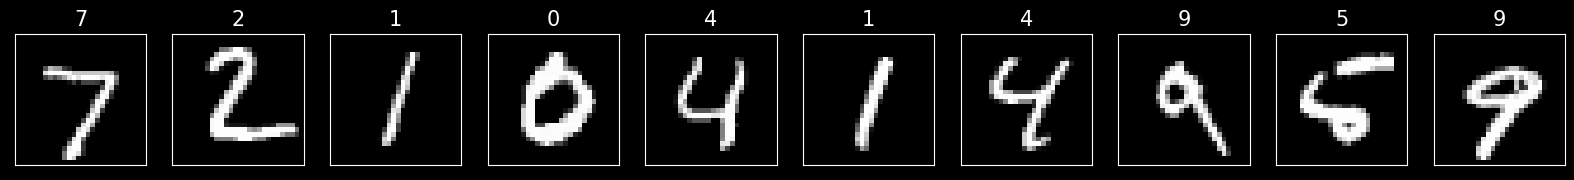

In [7]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(labels[i]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [8]:
def compute_loss_beta(model, x, beta):
    x_hat, kl_div = model(x)
    full_loss = recons_criterion(x_hat,x).mean(0).sum() - beta*(kl_div.mean(0).sum())
    return full_loss

def train_step_beta(model, x, optimizer, beta):
    # Compute the loss.
    model = model.to(device)
    x = x.to(device)
    loss = compute_loss_beta(model, x, beta)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

In [9]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 5
# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes,conv_channels = 5)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)

In [10]:
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the VAE

In [11]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('VAE_mnist_peladeau.pt'):
    model.load_state_dict(torch.load('./VAE_mnist_peladeau.pt'))

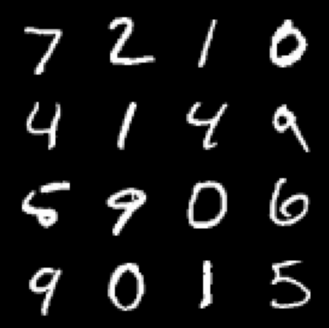

Epoch: 5, Test set ELBO: tensor([nan], grad_fn=<AddBackward0>), beta : 3


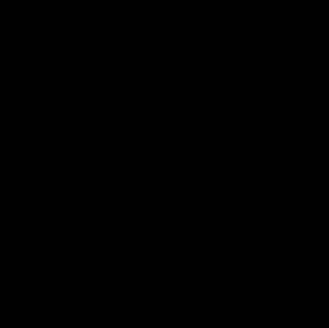

Epoch: 10, Test set ELBO: tensor([nan], grad_fn=<AddBackward0>), beta : 3


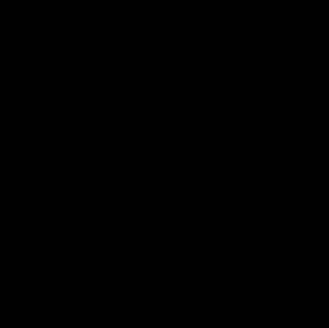

KeyboardInterrupt: 

In [12]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample.to(device))
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].cpu().detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#writer = SummaryWriter()

#Warm up
N_warm_up = 30
beta_end = 3


epochs=50
test_sample = imgs_test[0:16, :, :, :].to(device)

fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imgs_test[i, 0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
# Tight_layout minimizes the overlap between 2 sub-plots
#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()
if train:
    for epoch in range(1, epochs + 1):
        full_loss = torch.Tensor([0]).to(device)
        if trainBeta and epoch<N_warm_up:
            beta = beta_end*epoch/N_warm_up
        else:
            beta = beta_end
        # Forward pass: compute predicted y by passing x to the model.
        for i, (x, _) in enumerate(train_loader):
            full_loss += train_step_beta(model, x, optimizer, beta)
        #for i, (x, _) in enumerate(valid_loader):
        #    train_step(model, x, optimizer)
        if epoch%5==0:
            print('Epoch: {}, Test set ELBO: {}, beta : {}'.format(epoch, full_loss, beta))
            #grid = torchvision.utils.make_grid(test_sample)
            #writer.add_image('images', grid, 0)
            #writer.add_image(test_sample, test_sample)
            #writer.close()
            generate_and_save_images(model, epoch, test_sample)

In [ ]:
# Save trained NN parameters
torch.save(model.state_dict(), 'VAE_mnist_peladeau.pt')

In [ ]:
mu = np.linspace(-2, 2, 9)


model = model.to(device)
for i in range(n_latent):
    fig = plt.figure(figsize=(10, 8))
    for j in range(9):
        final_tensor = torch.zeros(n_latent)
        plt.subplot(1, 9, j+1)
        final_tensor = torch.zeros(n_latent).to(device)
        final_tensor[i] = mu[j]
        plt.imshow(model.decode(final_tensor.to(device)).cpu().detach().reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()